In [1]:
!pip install category_encoders

In [2]:
import os 
import pandas as pd
import numpy as np
import keras
import tensorflow as tf

In [3]:
os.chdir('/content/drive/MyDrive/Gcash/MultiInput')

In [4]:
data = pd.read_csv('merged_movies.csv')

In [5]:
# use this data with keywords
movie_keywords= pd.read_csv('movie_models_with_keywords.csv')
data = data.merge(movie_keywords[['tconst','keywords_extract']], how = 'left', on = 'tconst')

## Preprocessing

In [6]:
data = data.drop_duplicates(subset ='tconst')

cols = ['runtimeMinutes', 'averageRating','numVotes','weighted_rating', 'runtime','vote_average','vote_count', # important features
        'genres_x', 'genres_y', 'adjusted_budget', 'adjusted_revenue', 'release_month', # possible predictive features
        'has_well_known_director','has_well_known_actors', 'is_top_production_company', # binary extracted features
        'production_countries','belongs_to_collection','has_tag_line','homepage','spoken_languages','original_english',
        'popularity','keywords','keywords_extract','directors_name','primary_actors' # for text
        ]
movie_models = data[cols]

# for now select those with at least 5k votes
movie_models = movie_models[movie_models['numVotes'] > 5000]

remove_for_now_cols = ['runtime','vote_average','vote_count','genres_y','adjusted_revenue','popularity']
model_cols = [col for col in movie_models.columns if col not in remove_for_now_cols]
movie_models = movie_models[model_cols]

# same size as basic data
movie_models = movie_models[movie_models['adjusted_budget'].notnull()]

# binary weighted rating for now
movie_models['weighted_rating'] = (movie_models['weighted_rating'] > 7).astype(int)

In [7]:
movie_models.head()

,runtimeMinutes,averageRating,numVotes,weighted_rating,genres_x,adjusted_budget,release_month,has_well_known_director,has_well_known_actors,is_top_production_company,production_countries,belongs_to_collection,has_tag_line,homepage,spoken_languages,original_english,keywords,keywords_extract,directors_name,primary_actors
21,195.0,6.2,24191.0,0,"Drama,History,War",2.486208e+06,2.0,0,0,0,1,0,1,0,1,1,[],"['history film', 'film 1915', 'birth nation']",D.W. Griffith,"Lillian Gish,Mae Marsh,Henry B. Walthall"
33,163.0,7.7,15204.0,0,"Drama,History",1.933927e+08,9.0,0,0,0,1,0,1,0,1,1,[],"['tales intolerance', 'intolerance history', '...",D.W. Griffith,"Lillian Gish,Robert Harron,Mae Marsh"
52,90.0,7.3,10122.0,0,"Drama,Romance",0.000000e+00,5.0,0,0,0,1,0,0,0,1,1,[],NaN,D.W. Griffith,"Lillian Gish,Richard Barthelmess,Donald Crisp"
62,76.0,8.1,61683.0,1,"Horror,Mystery,Thriller",2.259963e+05,2.0,0,0,0,1,0,1,0,1,0,[],"['dr caligari', 'caligari eerie', 'caligari']",Robert Wiene,"Werner Krauss,Conrad Veidt,Friedrich Feher"
68,69.0,7.0,5294.0,0,"Drama,Horror,Sci-Fi",0.000000e+00,3.0,0,0,0,1,0,1,0,1,1,[],NaN,John S. Robertson,"John Barrymore,Martha Mansfield,Brandon Hurst"


In [8]:
# convert to text month
import calendar

movie_models['release_month'] = movie_models.release_month.apply(lambda x: calendar.month_name[int(x)])

In [9]:
movie_models.dtypes

runtimeMinutes               float64
averageRating                float64
numVotes                     float64
weighted_rating                int64
genres_x                      object
adjusted_budget              float64
release_month                 object
has_well_known_director        int64
has_well_known_actors          int64
is_top_production_company      int64
production_countries           int64
belongs_to_collection          int64
has_tag_line                   int64
homepage                       int64
spoken_languages               int64
original_english               int64
keywords                      object
keywords_extract              object
directors_name                object
primary_actors                object
dtype: object

In [10]:
num_cols = ['runtimeMinutes','adjusted_budget','production_countries','spoken_languages']
cat_cols1 = ['genres_x','release_month']
cat_cols2 = ['has_well_known_director','has_well_known_actors','is_top_production_company',
            'belongs_to_collection','has_tag_line','homepage','original_english']
cat_cols3 = ['keywords','keywords_extract','directors_name','primary_actors']

movie_models[cat_cols2] = movie_models[cat_cols2].astype(object)

In [11]:
movie_models.dtypes.sort_values()

weighted_rating                int64
spoken_languages               int64
production_countries           int64
runtimeMinutes               float64
averageRating                float64
numVotes                     float64
adjusted_budget              float64
keywords_extract              object
keywords                      object
original_english              object
homepage                      object
has_tag_line                  object
is_top_production_company     object
directors_name                object
has_well_known_actors         object
has_well_known_director       object
release_month                 object
genres_x                      object
belongs_to_collection         object
primary_actors                object
dtype: object

In [12]:
movie_models = movie_models[movie_models['adjusted_budget'] > 0]

In [13]:
movie_models.shape

(6189, 20)

#### Clean text features

In [14]:
# fill missing with space
movie_models[['directors_name','primary_actors']] = movie_models[['directors_name','primary_actors']].fillna('')

In [15]:
import ast
def separate_keywords(keywords_list):
    keywords = ast.literal_eval(keywords_list)
    return ' '.join(keywords)

movie_models['keywords'] = movie_models['keywords_extract'].apply(separate_keywords)
movie_models['keywords_extract'] = movie_models['keywords_extract'].apply(separate_keywords)
movie_models[['directors_name','primary_actors']] = movie_models[['directors_name','primary_actors']].applymap(lambda x: x.replace(',', ' '))
movie_models['text_feature'] =  movie_models[['keywords','directors_name','primary_actors','keywords_extract']].apply(lambda row: ' '.join(row.values.astype(str)), axis = 1)

In [16]:
movie_models.drop(columns = ['keywords','keywords_extract','directors_name','primary_actors'], inplace = True)

In [17]:
y = ['weighted_rating']
cols_A = ['runtimeMinutes', 'genres_x','adjusted_budget','release_month', 'has_well_known_director',
          'has_well_known_actors',	'is_top_production_company',	'production_countries',
          'belongs_to_collection', 'has_tag_line', 'homepage', 'spoken_languages', 'original_english']
cols_B = ['text_feature']

In [18]:
movie_models.shape

(6189, 17)

In [20]:
# get genre dummies and add
genres_dummy =  movie_models['genres_x'].str.get_dummies(',')
movie_models = pd.concat([movie_models, genres_dummy], axis = 1)
movie_models.drop(columns = ['genres_x'], inplace = True)

In [21]:
# log of budget
movie_models['adjusted_budget'] = np.log(movie_models['adjusted_budget'])

In [25]:
movie_models.drop(columns = ['averageRating','numVotes'], inplace = True)

#### Split train set and test set

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(movie_models.drop(columns=['weighted_rating'], axis = 1), movie_models['weighted_rating'], 
                                        stratify= movie_models['weighted_rating'], test_size=.25, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4641, 36)
(1548, 36)
(4641,)
(1548,)


In [28]:
X_train_A = X_train[num_cols + ['release_month'] + cat_cols2 + list(genres_dummy.columns)]
X_train_B = X_train['text_feature']
X_test_A = X_test[num_cols + ['release_month'] + cat_cols2 + list(genres_dummy.columns)]
X_test_B = X_test['text_feature']

In [31]:
print(X_train_A.shape)
print(X_test_A.shape)
print(X_train_A.columns)

print(X_train_B.shape)
print(X_test_B.shape)

print(y_train.mean())
print(y_test.mean())

(4641, 35)
(1548, 35)
Index(['runtimeMinutes', 'adjusted_budget', 'production_countries',
       'spoken_languages', 'release_month', 'has_well_known_director',
       'has_well_known_actors', 'is_top_production_company',
       'belongs_to_collection', 'has_tag_line', 'homepage', 'original_english',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi',
       'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')
(4641,)
(1548,)
0.23249299719887956
0.23255813953488372


### Model A: basic data

#### Preprocess

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_A[num_cols] = scaler.fit_transform(X_train_A[num_cols])
X_test_A[num_cols] =  scaler.transform(X_test_A[num_cols])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [35]:
import category_encoders as ce
encoder = ce.TargetEncoder(cols =  ['release_month'] +  cat_cols2 + list(genres_dummy.columns))
X_train_A = encoder.fit_transform(X_train_A, y_train)
X_test_A = encoder.transform(X_test_A)

# X_train_trans = X_train
# X_test_trans = X_test

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Modeling

In [36]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [38]:
input_A = keras.layers.Input(shape = X_train_A.shape[1:])
hidden1 = keras.layers.Dense(100, activation="relu")(input_A)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)
output = keras.layers.Dense(1, activation = 'sigmoid')(hidden2)
model_A = keras.Model(inputs=[input_A], outputs=[output])

In [50]:


# compile the model
model_A.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
history = model_A.fit(X_train_A, y_train, validation_split=0.2, epochs=500, verbose=0)


# evaluate the model
loss, accuracy, f1_score, precision, recall = model_A.evaluate(X_test_A, y_test, verbose=0)

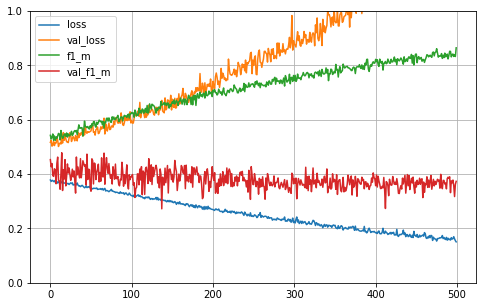

In [51]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history)[['loss','val_loss','f1_m','val_f1_m']].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

#### Overfit

In [53]:
print('Loss', loss)
print('Accuracy', accuracy)
print('F1 Score', f1_score)
print('Precision', precision)
print('Recall', recall)

Loss 1.0767982006072998
Accuracy 0.7435400485992432
F1 Score 0.43643203377723694
Precision 0.44257786870002747
Recall 0.4659811854362488


              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1188
           1       0.45      0.46      0.45       360

    accuracy                           0.74      1548
   macro avg       0.64      0.64      0.64      1548
weighted avg       0.75      0.74      0.74      1548

Logloss 8.857917149522248
****************************************************************************************************
Confusion matrix


[Text(0.5, 0, 'Predicted 0'), Text(1.5, 0, 'Predicted 1')]

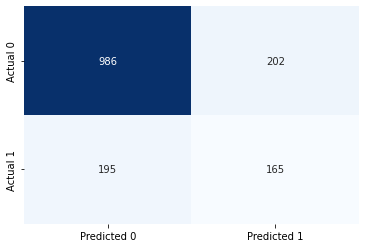

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, log_loss 
import seaborn as sns 

y_pred = model_A.predict(X_test_A)
y_pred = (y_pred >= .5).astype(int)
print(classification_report(y_pred= y_pred, y_true= y_test))
print('Logloss', log_loss(y_pred= y_pred, y_true= y_test))
print('*' * 100)
print('Confusion matrix')     
cm = confusion_matrix(y_pred= y_pred, y_true= y_test)
g = sns.heatmap(cm, annot=True, cbar = False, fmt = 'g', cmap ='Blues')
g.set_yticklabels(['Actual 0', 'Actual 1'])
g.set_xticklabels(['Predicted 0', 'Predicted 1'])

### Model B

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df = .5, analyzer = 'word', stop_words = 'english', ngram_range = (1,2))
tfidf_vectorizer.fit(X_train_B)
X_train_B = tfidf_vectorizer.transform(X_train_B)
X_test_B = tfidf_vectorizer.transform(X_test_B)

In [66]:
print(X_test_B.shape)
print(X_train_B.shape)

(1548, 66393)
(4641, 66393)


In [68]:
X_train_B = X_train_B.toarray()
X_test_B = X_test_B.toarray()

In [70]:
input_B = keras.layers.Input(shape = X_train_B.shape[1:])
hidden1 = keras.layers.Dense(100, activation="relu")(input_B)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)
output = keras.layers.Dense(1, activation = 'sigmoid')(hidden2)
model_B = keras.Model(inputs=[input_B], outputs=[output])



# compile the model
model_B.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
history = model_B.fit(X_train_B, y_train, epochs=20, verbose=0)


# evaluate the model
loss, accuracy, f1_score, precision, recall = model_B.evaluate(X_test_B, y_test, verbose=0)

In [71]:
print('Loss', loss)
print('Accuracy', accuracy)
print('F1 Score', f1_score)
print('Precision', precision)
print('Recall', recall)

Loss 1.322284460067749
Accuracy 0.7170542478561401
F1 Score 0.3798636496067047
Precision 0.3919737935066223
Recall 0.38597041368484497


              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1188
           1       0.39      0.38      0.39       360

    accuracy                           0.72      1548
   macro avg       0.60      0.60      0.60      1548
weighted avg       0.72      0.72      0.72      1548

Logloss 9.772711094325453
****************************************************************************************************
Confusion matrix


[Text(0.5, 0, 'Predicted 0'), Text(1.5, 0, 'Predicted 1')]

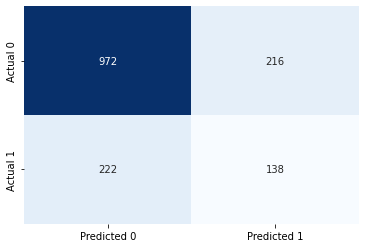

In [73]:
y_pred = model_B.predict(X_test_B)
y_pred = (y_pred >= .5).astype(int)
print(classification_report(y_pred= y_pred, y_true= y_test))
print('Logloss', log_loss(y_pred= y_pred, y_true= y_test))
print('*' * 100)
print('Confusion matrix')     
cm = confusion_matrix(y_pred= y_pred, y_true= y_test)
g = sns.heatmap(cm, annot=True, cbar = False, fmt = 'g', cmap ='Blues')
g.set_yticklabels(['Actual 0', 'Actual 1'])
g.set_xticklabels(['Predicted 0', 'Predicted 1'])

Similar f1 score with logistic regression

#### Combine models

In [75]:
input_A = keras.layers.Input(shape = X_train_A.shape[1:], name = 'Input_A')
hidden1_A = keras.layers.Dense(100, activation="relu")(input_A)
hidden2_A = keras.layers.Dense(100, activation="relu")(hidden1_A)
input_B = keras.layers.Input(shape = X_train_B.shape[1:], name = 'Input_B')
hidden1_B = keras.layers.Dense(100, activation="relu")(input_B)
hidden2_B = keras.layers.Dense(100, activation="relu")(hidden1_B)
concat = keras.layers.concatenate([hidden2_A, hidden2_B])
output =  keras.layers.Dense(1, activation = 'sigmoid')(concat)
model = keras.Model(inputs = [input_A, input_B], outputs = [output])

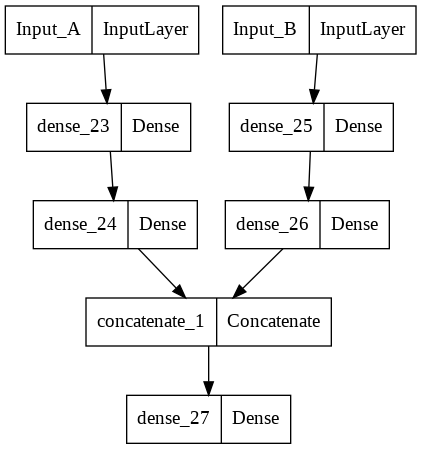

In [77]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=False, show_layer_names=True)

In [78]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
history = model.fit((X_train_A,X_train_B), y_train, epochs=20, verbose=0)

# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate((X_test_A, X_test_B), y_test, verbose=0)

In [79]:
print('Loss', loss)
print('Accuracy', accuracy)
print('F1 Score', f1_score)
print('Precision', precision)
print('Recall', recall)

Loss 1.4345135688781738
Accuracy 0.7248061895370483
F1 Score 0.37814638018608093
Precision 0.3994244635105133
Recall 0.3804303705692291


              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1188
           1       0.40      0.38      0.39       360

    accuracy                           0.72      1548
   macro avg       0.61      0.60      0.61      1548
weighted avg       0.72      0.72      0.72      1548

Logloss 9.504960893614612
****************************************************************************************************
Confusion matrix


[Text(0.5, 0, 'Predicted 0'), Text(1.5, 0, 'Predicted 1')]

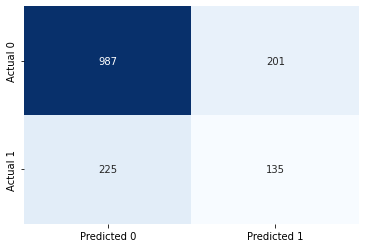

In [80]:
y_pred = model.predict((X_test_A, X_test_B))
y_pred = (y_pred >= .5).astype(int)
print(classification_report(y_pred= y_pred, y_true= y_test))
print('Logloss', log_loss(y_pred= y_pred, y_true= y_test))
print('*' * 100)
print('Confusion matrix')     
cm = confusion_matrix(y_pred= y_pred, y_true= y_test)
g = sns.heatmap(cm, annot=True, cbar = False, fmt = 'g', cmap ='Blues')
g.set_yticklabels(['Actual 0', 'Actual 1'])
g.set_xticklabels(['Predicted 0', 'Predicted 1'])